In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Cropping2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout, Lambda,BatchNormalization,Activation
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt

C:\Users\Tanma\AppData\Roaming\Python\Python310\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
path = ''
image_path = os.path.join(path, 'data/images/')
mask_path = os.path.join(path, 'data/panoptic/')
image_list_orig = os.listdir(image_path)
mask_list_orig = os.listdir(mask_path)
image_list = [os.path.join(image_path, i) for i in image_list_orig if i.endswith('.jpg')][:100]
mask_list = [os.path.join(mask_path, i) for i in mask_list_orig if i.endswith('.png')][:100]

test_image_path = os.path.join(path, 'val_cityscapes/img/')
test_image_list_orig = os.listdir(test_image_path)
test_image_list = [test_image_path+i for i in test_image_list_orig if i.endswith('.png')]


In [3]:
def process_test_path(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (96, 128))
    return img

# Preprocess testing data
test_image_filenames = tf.constant(test_image_list)

# Convert to TensorFlow Dataset
test_image_ds = tf.data.Dataset.from_tensor_slices(test_image_filenames)

# Apply preprocessing function to the dataset
test_image_ds = test_image_ds.map(process_test_path)


C:\Users\Tanma\AppData\Local\Temp\ipykernel_11400\1645610153.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
C:\Users\Tanma\AppData\Local\Temp\ipykernel_11400\1645610153.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

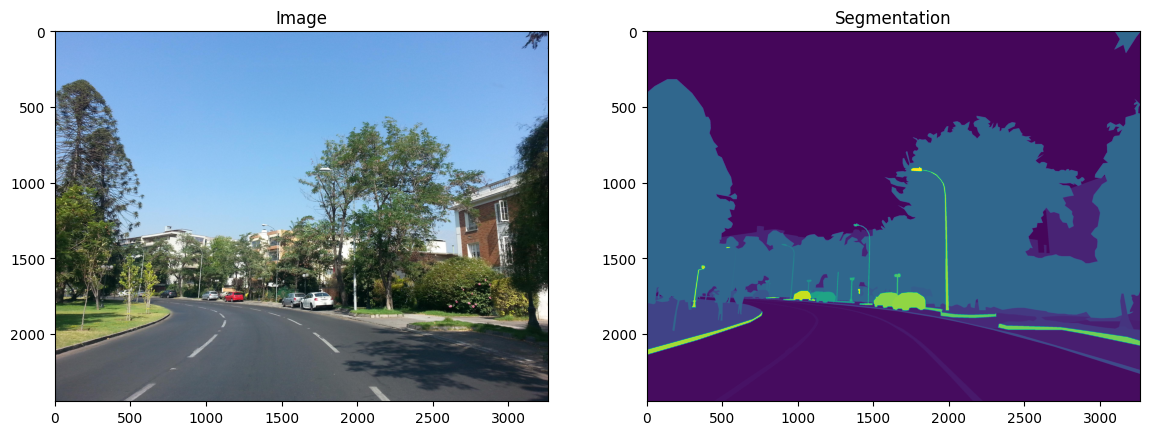

In [4]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

In [5]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'data\\images\\--NSVcUgfVhFd6uzkqHOOg.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data\\panoptic\\--NSVcUgfVhFd6uzkqHOOg.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'data\\images\\--SWG8TJo7vrbZ_x5YLj6A.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data\\panoptic\\--SWG8TJo7vrbZ_x5YLj6A.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'data\\images\\--WOpVBuHlCygAUADkttpg.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data\\panoptic\\--WOpVBuHlCygAUADkttpg.png'>)


In [6]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

test_filenames = tf.constant(test_image_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))


for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'data/images/--jRsD9anHdGxv4ZOCQktA.jpg', shape=(), dtype=string)
tf.Tensor(b'data/panoptic/--jRsD9anHdGxv4ZOCQktA.png', shape=(), dtype=string)


In [7]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)
num_classes = 256
def preprocess_labels(dataset, num_classes):
    def map_labels(image, label):
        label = tf.clip_by_value(label, 0, num_classes - 1)  # Clip to valid range
        return image, label
    return dataset.map(map_labels)

processed_image_ds = preprocess_labels(processed_image_ds, num_classes)


In [8]:
class TFActivationLayer(tf.keras.layers.Layer):
    def __init__(self, activation_func, **kwargs):
        super().__init__(**kwargs)
        self.activation_func = tf.keras.activations.get(activation_func)

    def call(self, inputs):
        return self.activation_func(inputs)

    def get_config(self):
        config = super().get_config()
        config.update({"activation_func": tf.keras.activations.serialize(self.activation_func)})
        return config


def ghost_module(inputs, input_size, output_size, kernel_size, ratio, dw_size, stride, relu_func):
    initial_channel_size = output_size // ratio
    new_channel_size = initial_channel_size

    # Primary Conv
    x1 = tf.keras.layers.Conv2D(initial_channel_size, kernel_size, strides=stride, padding='same', use_bias=False)(inputs)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = TFActivationLayer(relu_func)(x1)  # Use custom TFActivationLayer

    # Cheap Conv
    x2 = tf.keras.layers.DepthwiseConv2D(dw_size, strides=1, padding='same', use_bias=False)(x1)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = TFActivationLayer(relu_func)(x2)  # Use custom TFActivationLayer
    x2 = tf.keras.layers.Conv2D(new_channel_size, 1, strides=1, padding='same', use_bias=False)(x2)

    # Concatenate primary and cheap conv outputs
    out = tf.keras.layers.Concatenate(axis=-1)([x1, x2])

    return out


def squeeze_excite_block(inputs, ratio=16):
    channels = inputs.shape[-1]

    # Squeeze: Global Average Pooling
    squeeze = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    squeeze = tf.keras.layers.Reshape((1, 1, channels))(squeeze)

    # Excitation: Fully connected layers
    excitation = tf.keras.layers.Dense(units=channels // ratio, activation='relu')(squeeze)
    excitation = tf.keras.layers.Dense(units=channels, activation='sigmoid')(excitation)

    # Scale the input tensor with the excitation output
    scale = tf.keras.layers.Multiply()([inputs, excitation])

    return scale



class UnMaxPool(tf.keras.layers.Layer):
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        height, width, channels = inputs.get_shape().as_list()[1:]

        max_indices = tf.keras.backend.argmax(inputs, axis=3)
        unraveled_indices = tf.one_hot(max_indices, depth=channels, dtype=inputs.dtype)

        updates = tf.ones_like(unraveled_indices, dtype=inputs.dtype)
        updates = tf.reshape(updates, [batch_size, -1])
        unmapped_flat = tf.scatter_nd(tf.reshape(tf.where(unraveled_indices), [-1, 3]),
                                      updates,
                                      [batch_size, height, width, channels])

        unmapped = tf.reshape(unmapped_flat, [batch_size, height, width, channels])
        return unmapped



def double_conv(inputs, filters, kernel_size, padding='same', activation='relu'):
   
    # First convolution layer
    conv1 = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation=activation)(inputs)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)

    # Second convolution layer
    conv2 = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation=activation)(conv1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)

    return conv2

def transpose_conv(inputs, filters, kernel_size, strides):
    batch_size, height, width, channels = inputs.shape
    output_height = height * strides
    output_width = width * strides

    transpose_conv = tf.keras.layers.Conv2DTranspose(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        padding='valid',
        use_bias=False
    )

    outputs = transpose_conv(inputs)
    outputs = tf.keras.layers.BatchNormalization()(outputs)

    return outputs

class ConcatenateLayer(tf.keras.layers.Layer):
    def __init__(self, axis=-1, **kwargs):
        super(ConcatenateLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        # Determine the target height and width from the first input
        target_height = tf.shape(inputs[0])[1]
        target_width = tf.shape(inputs[0])[2]

        # Resize all inputs to match the target height and width
        resized_inputs = [
            tf.image.resize(x, size=(target_height, target_width), method='bilinear')
            for x in inputs
        ]

        # Concatenate the resized tensors along the specified axis
        return tf.concat(resized_inputs, axis=self.axis)

    def get_config(self):
        config = super(ConcatenateLayer, self).get_config()
        config.update({"axis": self.axis})
        return config






In [9]:
def GhostUNet(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    gm1 = ghost_module(inputs, input_size=3, output_size=64, kernel_size=3, ratio=2, dw_size=3, stride=1, relu_func=tf.nn.leaky_relu)
    dw1 = tf.keras.layers.DepthwiseConv2D(3, strides=1, padding='same', use_bias=False)(gm1)
    gm1 = ghost_module(dw1, input_size=3, output_size=64, kernel_size=3, ratio=2, dw_size=3, stride=1, relu_func=tf.nn.leaky_relu)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid')(gm1)  # Changed strides and padding
    print(pool1.shape)

    gm2 = ghost_module(pool1, input_size=3, output_size=64, kernel_size=3, ratio=2, dw_size=3, stride=1, relu_func=tf.nn.leaky_relu)
    dw2 = tf.keras.layers.DepthwiseConv2D(3, strides=1, padding='same', use_bias=False)(gm2)
    se1 = squeeze_excite_block(inputs, 64)
    gm2 = ghost_module(se1, input_size=3, output_size=64, kernel_size=3, ratio=2, dw_size=3, stride=1, relu_func=tf.nn.leaky_relu)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(gm2)
    print(pool2.shape)

    gm3 = ghost_module(pool2, input_size=3, output_size=64, kernel_size=3, ratio=2, dw_size=3, stride=1, relu_func=tf.nn.leaky_relu)
    dw3 = tf.keras.layers.DepthwiseConv2D(3, strides=1, padding='same', use_bias=False)(gm3)
    gm3 = ghost_module(dw3, input_size=3, output_size=64, kernel_size=3, ratio=2, dw_size=3, stride=1, relu_func=tf.nn.leaky_relu)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(gm3)
    print(pool3.shape)

    gm4 = ghost_module(pool3, input_size=3, output_size=64, kernel_size=3, ratio=2, dw_size=3, stride=1, relu_func=tf.nn.leaky_relu)
    dw4 = tf.keras.layers.DepthwiseConv2D(3, strides=1, padding='same', use_bias=False)(gm4)
    se2 = squeeze_excite_block(dw4, 64)
    gm4 = ghost_module(se2, input_size=3, output_size=64, kernel_size=3, ratio=2, dw_size=3, stride=1, relu_func=tf.nn.leaky_relu)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(gm4)
    print(pool4.shape)

    gm5 = ghost_module(pool4, input_size=3, output_size=64, kernel_size=3, ratio=2, dw_size=3, stride=1, relu_func=tf.nn.leaky_relu)
    dw5 = tf.keras.layers.DepthwiseConv2D(3, strides=1, padding='same', use_bias=False)(gm5)
    gm5 = ghost_module(dw5, input_size=3, output_size=64, kernel_size=3, ratio=2, dw_size=3, stride=1, relu_func=tf.nn.leaky_relu)
    pool5 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(gm5)
    print(pool5.shape)

    unmaxpool = UnMaxPool()(pool5)
    print(unmaxpool.shape)

    # Decoder
    up1 = transpose_conv(pool5, filters=128, kernel_size=2, strides=2)
    dconv1 = double_conv(up1, filters=64, kernel_size=3)
    concat1 = ConcatenateLayer(axis=-1)([dconv1, pool4])

    print(concat1.shape)

    up2 = transpose_conv(concat1, filters=128, kernel_size=2, strides=2)
    dconv2 = double_conv(up2, filters=64, kernel_size=3)
    concat2 = ConcatenateLayer(axis=-1)([dconv2, pool3])
    print(concat2.shape)

    up3 = transpose_conv(concat2, filters=128, kernel_size=2, strides=2)
    dconv3 = double_conv(up3, filters=64, kernel_size=3)
    concat3 = ConcatenateLayer(axis=-1)([dconv3, pool2])
    print(concat3.shape)

    up4 = transpose_conv(concat3, filters=128, kernel_size=2, strides=2)
    dconv4 = double_conv(up4, filters=64, kernel_size=3)
    concat4 = ConcatenateLayer(axis=-1)([dconv4, pool1])
    print(concat4.shape)

    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(concat4)
    print(outputs.shape)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model


In [10]:
input_shape = (96, 128, 3)  # Example input shape
num_classes = 256  # Example number of classes
model = GhostUNet(input_shape, num_classes)


(None, 95, 127, 64)
(None, 48, 64, 64)
(None, 24, 32, 64)
(None, 12, 16, 64)
(None, 6, 8, 64)
(None, 6, 8, 64)
(None, 12, 16, 128)
(None, 24, 32, 128)
(None, 48, 64, 128)
(None, 96, 128, 128)
(None, 96, 128, 256)


In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 96, 128, 3)        │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d      │ (None, 3)                 │               0 │ input_layer[0][0]          │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 1, 1, 3)           │               0 │ global_average_pooling2d[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 1, 1, 0)           │               0 │ reshape[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1, 1, 3)           │               3 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply (Multiply)           │ (None, 96, 128, 3)        │               0 │ input_layer[0][0],         │
│                               │                           │                 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 96, 128, 32)       │             864 │ multiply[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_6         │ (None, 96, 128, 32)       │             128 │ conv2d_6[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ tf_activation_layer_6         │ (None, 96, 128, 32)       │               0 │ batch_normalization_6[0][… │
│ (TFActivationLayer)           │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ depthwise_conv2d_5            │ (None, 96, 128, 32)       │             288 │ tf_activation_layer_6[0][… │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_7         │ (None, 96, 128, 32)       │             128 │ depthwise_conv2d_5[0][0]   │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ tf_activation_layer_7         │ (None, 96, 128, 32)       │               0 │ batch_normalization_7[0][… │
│ (TFActivationLayer)           │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 96, 128, 32)       │           1,024 │ tf_activation_layer_7[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_3 (Concatenate)   │ (None, 96, 128, 64)       │               

 Total params: 856,740 (3.27 MB)

 Trainable params: 853,540 (3.26 MB)

 Non-trainable params: 3,200 (12.50 KB)

In [12]:
def pixel_accuracy(y_true, y_pred):
    # Convert predicted probabilities to predicted labels
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    # Ensure y_pred_labels has the same shape as y_true
    y_pred_labels = tf.reshape(y_pred_labels, tf.shape(y_true))
    # Cast y_true to the same data type as y_pred_labels
    y_true = tf.cast(y_true, y_pred_labels.dtype)
    # Compare predicted labels to true labels and compute accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred_labels), tf.float32))
    return accuracy

def mean_iou(y_true, y_pred):
    # Convert predicted probabilities to predicted labels
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    # Ensure y_pred_labels has the same shape as y_true
    y_pred_labels = tf.reshape(y_pred_labels, tf.shape(y_true))
    # Compute IoU for each class
    iou = []
    for i in range(1, 66):  # Excluding background class 0
        intersection = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, i), tf.equal(y_pred_labels, i)), tf.float32))
        union = tf.reduce_sum(tf.cast(tf.logical_or(tf.equal(y_true, i), tf.equal(y_pred_labels, i)), tf.float32))
        iou.append((intersection + 1e-7) / (union + 1e-7))  # Add small epsilon to avoid division by zero
    # Compute mean IoU across classes
    mean_iou = tf.reduce_mean(iou)
    return mean_iou

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """
    Compute the Dice Similarity Coefficient.

    Args:
        y_true: Ground truth labels, shape (batch_size, height, width, num_classes).
        y_pred: Predicted labels, shape (batch_size, height, width, num_classes).
        smooth: Smoothing factor to avoid division by zero.

    Returns:
        Dice coefficient as a scalar.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    dice = (2. * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(dice)

def hausdorff_distance(y_true, y_pred):
    """
    Compute the Hausdorff Distance between two binary masks.

    Args:
        y_true: Ground truth binary mask, shape (height, width).
        y_pred: Predicted binary mask, shape (height, width).

    Returns:
        Hausdorff Distance as a scalar.
    """
    # Ensure binary masks
    y_true = np.asarray(y_true > 0.5, dtype=np.bool_)
    y_pred = np.asarray(y_pred > 0.5, dtype=np.bool_)

    # Get the coordinates of the points in the masks
    true_points = np.argwhere(y_true)
    pred_points = np.argwhere(y_pred)

    # Compute directed Hausdorff distances
    forward_distance = directed_hausdorff(true_points, pred_points)[0]
    backward_distance = directed_hausdorff(pred_points, true_points)[0]

    # Return the maximum of the two directed distances
    return max(forward_distance, backward_distance)

def precision(y_true, y_pred):
    """
    Compute Precision for segmentation.

    Args:
        y_true: Ground truth labels, shape (batch_size, height, width).
        y_pred: Predicted logits, shape (batch_size, height, width, num_classes).

    Returns:
        Precision as a scalar.
    """
    y_pred_labels = tf.argmax(y_pred, axis=-1)  # Convert logits to class labels
    
    # Remove the extra dimension in y_true if it exists
    y_true = tf.squeeze(y_true, axis=-1)  # Shape (batch_size, height, width)
    
    # Ensure consistency in data types (cast both to int64)
    y_true = tf.cast(y_true, tf.int64)
    y_pred_labels = tf.cast(y_pred_labels, tf.int64)

    # Exclude background class (0)
    true_positive = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred_labels), tf.float32))
    predicted_positive = tf.reduce_sum(tf.cast(tf.not_equal(y_pred_labels, 0), tf.float32))
    
    return true_positive / (predicted_positive + 1e-7)  # Avoid division by zero

def recall(y_true, y_pred):
    """
    Compute Recall.

    Args:
        y_true: Ground truth labels, shape (batch_size, height, width).
        y_pred: Predicted logits, shape (batch_size, height, width, num_classes).

    Returns:
        Recall as a scalar.
    """
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    
    # Remove the extra dimension in y_true if it exists
    y_true = tf.squeeze(y_true, axis=-1)
    
    # Ensure consistency in data types (cast both to int64)
    y_true = tf.cast(y_true, tf.int64)
    y_pred_labels = tf.cast(y_pred_labels, tf.int64)

    true_positive = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred_labels), tf.float32))
    actual_positive = tf.reduce_sum(tf.cast(tf.not_equal(y_true, 0), tf.float32))  # Exclude background
    return true_positive / (actual_positive + 1e-7)  # Avoid division by zero


def f1_score(y_true, y_pred):
    """
    Compute F1 Score for segmentation.

    Args:
        y_true: Ground truth labels, shape (batch_size, height, width).
        y_pred: Predicted logits, shape (batch_size, height, width, num_classes).

    Returns:
        F1 Score as a scalar.
    """
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    
    return 2 * (precision_value * recall_value) / (precision_value + recall_value + 1e-7)



model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[pixel_accuracy, precision, recall])

In [13]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(3024, 4032, 1)


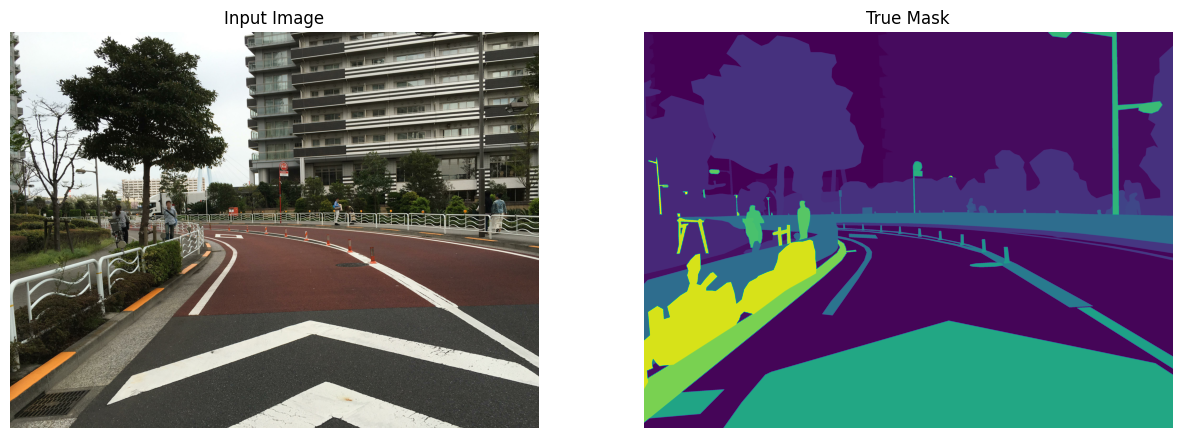

In [14]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


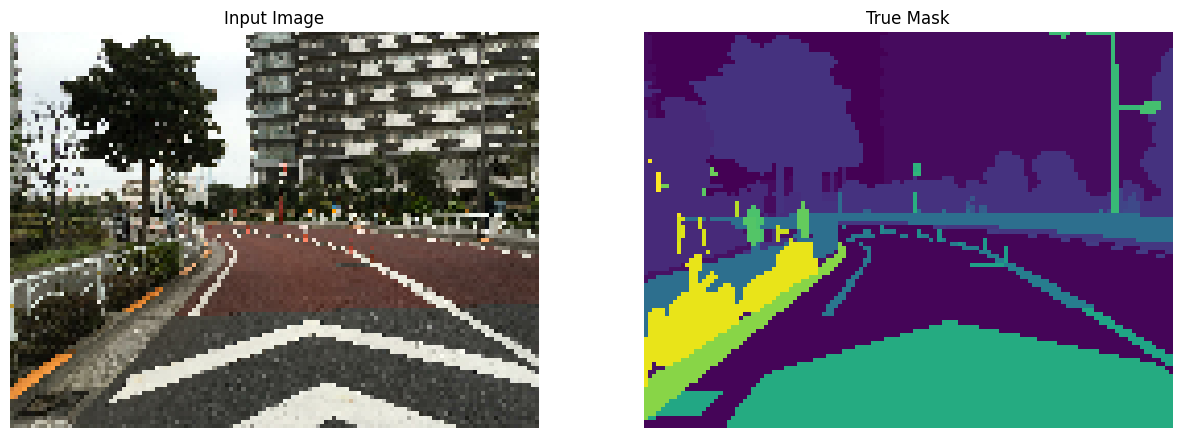

In [15]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [16]:
EPOCHS =150
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 4
train_dataset = (
    processed_image_ds
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Check the dataset structure
print(train_dataset.element_spec)

# Train the model
model_history = model.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(None, 96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/150


C:\Users\Tanma\AppData\Roaming\Python\Python310\site-packages\keras\src\backend\tensorflow\nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


25/25 ━━━━━━━━━━━━━━━━━━━━ 52s 608ms/step - loss: 4.7362 - pixel_accuracy: 0.2192 - precision: 0.2193 - recall: 0.2195
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 557ms/step - loss: 3.4701 - pixel_accuracy: 0.3504 - precision: 0.3504 - recall: 0.3507
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 546ms/step - loss: 3.0713 - pixel_accuracy: 0.3608 - precision: 0.3608 - recall: 0.3611
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 545ms/step - loss: 2.9448 - pixel_accuracy: 0.3641 - precision: 0.3641 - recall: 0.3644
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 554ms/step - loss: 2.8917 - pixel_accuracy: 0.3646 - precision: 0.3646 - recall: 0.3650
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 550ms/step - loss: 2.8327 - pixel_accuracy: 0.3705 - precision: 0.3705 - recall: 0.3709
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 545ms/step - loss: 2.7944 - pixel_accuracy: 0.3811 - precision: 0.3811 - recall: 0.3814
Epoch 8/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 549ms/step - loss: 2.7615 - pixel_accuracy: 0.3851 -

In [17]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [18]:
# plt.plot(model_history.history[mean_iou, pixel_accuracy])

In [19]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


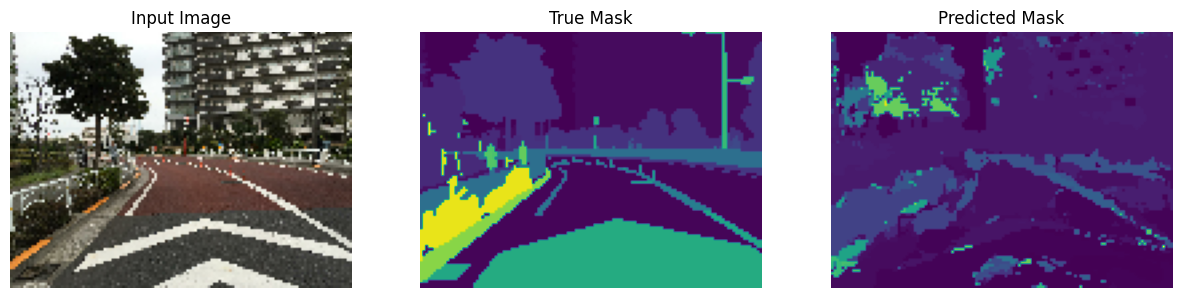

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


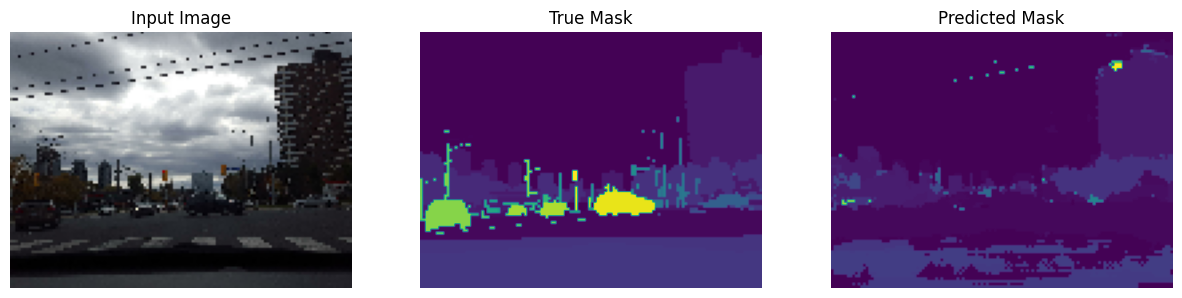

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


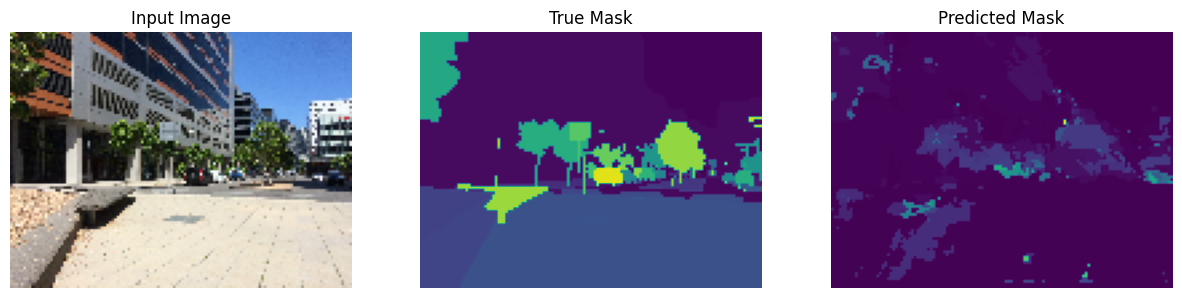

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


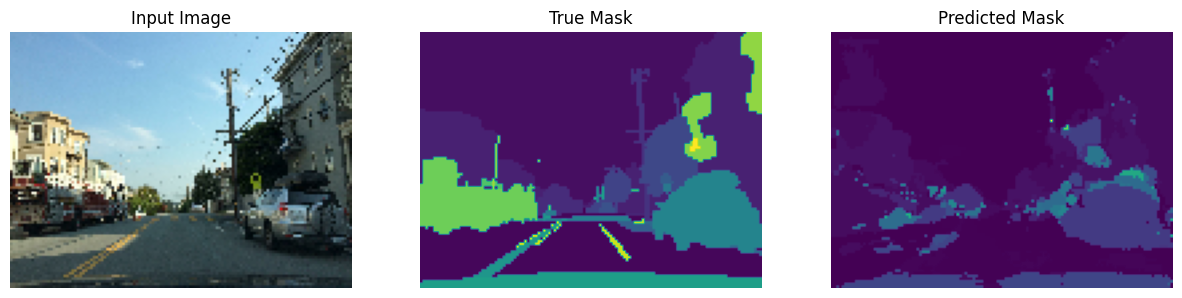

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


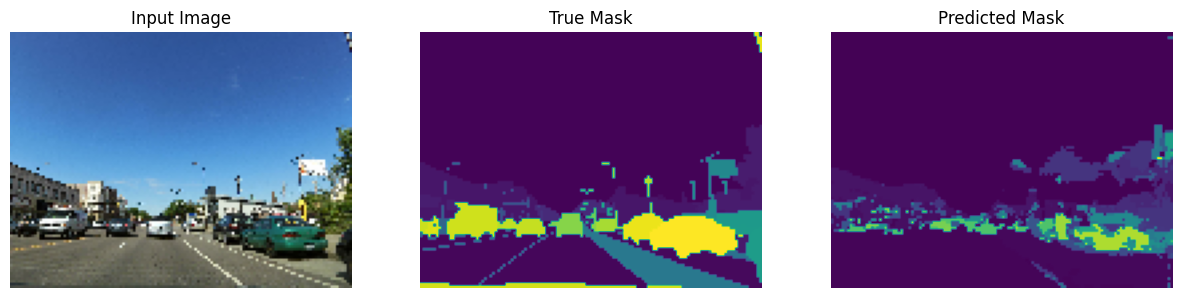

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


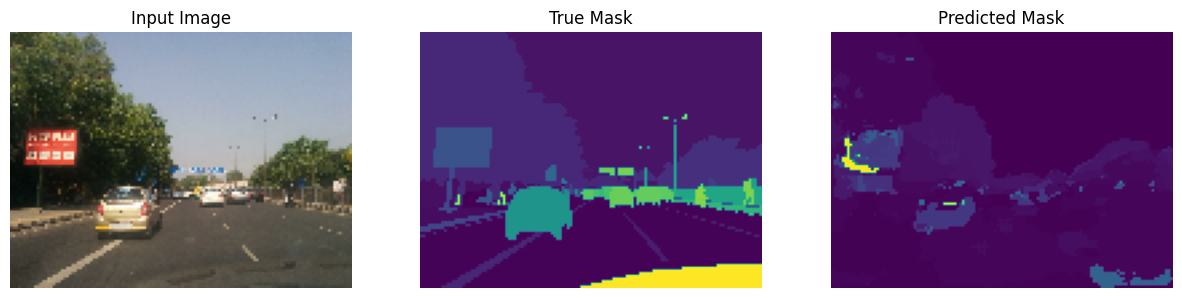

In [20]:
show_predictions(train_dataset, 6)

In [21]:
def preprocess_test(image):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    return input_image

In [1]:

# import os
# import cv2  # Assuming you're using OpenCV to load images
# import numpy as np
# import tensorflow as tf

# # Assuming test_masks_folder contains the ground truth masks
# test_masks_folder = "test_masks"

# # Load ground truth masks
# true_masks = []
# for image_path in test_image_list:
#     mask_path = os.path.join(test_masks_folder, os.path.basename(image_path))
#     true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
#     true_masks.append(true_mask)

# # Make predictions using the trained model
# pred_masks = []
# for test_image in test_image_ds.take(len(test_image_list)):
#     test_image = test_image[tf.newaxis, ...]
#     pred_mask = model.predict(test_image)
#     pred_masks.append(pred_mask)

# def create_rgb_mask(mask):
#     """
#     Converts a single-channel mask to a three-channel RGB mask
#     """
#     return cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

# def convert_mask_color(mask, color_scheme):
#     """
#     Converts a mask's color scheme according to the given color_scheme dictionary
#     """
#     converted_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)  # Create an empty RGB mask
#     for value in color_scheme:
#         converted_mask[mask == value] = color_scheme[value]
#     return converted_mask

# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors

# def show_test_predictions(test_images_preprocessed, pred_masks, true_masks, num=1):
#     """
#     Displays the first num images of the test set along with predicted and ground truth masks
#     """
#     cmap = plt.cm.viridis  # Use the 'viridis' colormap

#     for i, (test_image, pred_mask, true_mask) in enumerate(zip(test_images_preprocessed, pred_masks, true_masks)):
#         if i >= num:
#             break
        
#         display_list = [test_image, create_mask(pred_mask), true_mask]
#         title = ['Test Image', 'Predicted Mask', 'True Mask']
#         display(display_list, title, cmap)

# def display(display_list, title=None, cmap=None):
#     """
#     Displays a list of images with their corresponding titles
#     """
#     plt.figure(figsize=(15, 15))
#     for i in range(len(display_list)):
#         plt.subplot(1, len(display_list), i+1)
#         plt.title(title[i])
#         if cmap is not None and i == len(display_list) - 1:  # Apply colormap only to the last image
#             plt.imshow(display_list[i], cmap=cmap)
#         else:
#             plt.imshow(display_list[i])
#         plt.axis('off')
#     plt.show()

# # Display predictions for the test set along with ground truth
# show_test_predictions(test_image_ds, pred_masks, true_masks, num=17)



In [ ]:
def load_image_mask_pairs(image_folder, mask_folder):
    image_paths = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder)])
    mask_paths = sorted([os.path.join(mask_folder, f) for f in os.listdir(mask_folder)])
    
    images = [tf.keras.preprocessing.image.load_img(path) for path in image_paths]
    masks = [tf.keras.preprocessing.image.load_img(path) for path in mask_paths]
    
    return images, masks

# Function to display images, predictions, and ground truths
def display_predictions_from_folder(model, image_folder, mask_folder, num_images=6):
    images, masks = load_image_mask_pairs(image_folder, mask_folder)
    
    plt.figure(figsize=(18, 12))
    
    for i in range(num_images):
        image_array = tf.keras.preprocessing.image.img_to_array(images[i]) / 255.0
        prediction = model.predict(tf.expand_dims(image_array, axis=0))[0]
        
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(images[i])
        plt.title("Image")
        plt.axis('off')
        
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(tf.argmax(prediction, axis=-1))
        plt.title("Predicted Mask")
        plt.axis('off')
        
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(masks[i])
        plt.title("Ground Truth Mask")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function with your folders
display_predictions_from_folder(model, 'train_cityscapes/img', 'train_cityscapes/label')